<a href="https://colab.research.google.com/github/mcash8/Info-Theory-Project/blob/main/IBnet_SaveActivations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Training

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp drive/MyDrive/utils.py /content/
!cp drive/MyDrive/loggingreporter.py /content/
!cp drive/MyDrive/datasets/ -r /content/

In [ ]:
!pip install pathlib2
!pip install tensorflow==2.1.0
!pip install keras==2.3.1

In [43]:
import keras
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np

import utils
import loggingreporter 

cfg = {}
cfg['SGD_BATCHSIZE']    = 256
cfg['SGD_LEARNINGRATE'] = 0.0004
cfg['NUM_EPOCHS']       = 10000
cfg['FULL_MI']          = True

#cfg['ACTIVATION'] = 'tanh'
#cfg['ACTIVATION'] = 'relu'
#cfg['ACTIVATION'] = 'softsign'
cfg['ACTIVATION'] = 'softplus'

# How many hidden neurons to put into each of the layers
cfg['LAYER_DIMS'] = [10,7,5,4,3] # original IB network
ARCH_NAME =  '-'.join(map(str,cfg['LAYER_DIMS']))

trn, tst = utils.get_IB_data('2017_12_21_16_51_3_275766')

# Where to save activation and weights data
cfg['SAVE_DIR'] = 'rawdata/' + cfg['ACTIVATION'] + '_' + ARCH_NAME 

In [ ]:
input_layer = keras.layers.Input((trn.X.shape[1],))
clayer = input_layer
for n in cfg['LAYER_DIMS']:
    clayer = keras.layers.Dense(n, 
                                activation=cfg['ACTIVATION'],
                                kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=1/np.sqrt(float(n)), seed=None),
                                bias_initializer='zeros'
                               )(clayer)
output_layer = keras.layers.Dense(trn.nb_classes, activation='softmax')(clayer)

model = keras.models.Model(inputs=input_layer, outputs=output_layer)
optimizer = tf.keras.optimizers.Adam(learning_rate=cfg['SGD_LEARNINGRATE'])

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

In [ ]:
def do_report(epoch):
    # Only log activity for some epochs.  Mainly this is to make things run faster.
    if epoch < 20:       # Log for all first 20 epochs
        return True
    elif epoch < 100:    # Then for every 5th epoch
        return (epoch % 5 == 0)
    elif epoch < 2000:    # Then every 10th
        return (epoch % 20 == 0)
    else:                # Then every 100th
        return (epoch % 100 == 0)
    
reporter = loggingreporter.LoggingReporter(cfg=cfg, 
                                          trn=trn, 
                                          tst=tst, 
                                          do_save_func=do_report)
r = model.fit(x=trn.X, y=trn.Y, 
              verbose    = 2, 
              batch_size = cfg['SGD_BATCHSIZE'],
              epochs     = cfg['NUM_EPOCHS'],
              # validation_data=(tst.X, tst.Y),
              callbacks  = [reporter,])


#Compute MI

In [15]:
!cp drive/MyDrive/kde.py /content/
!cp drive/MyDrive/simplebinmi.py /content/

In [20]:
!cp drive/MyDrive/rawdata/tanh_10-\7-\5-\4-\3/ -r /content/rawdata/

In [49]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function
import os
import _pickle as cPickle
from collections import defaultdict, OrderedDict

import numpy as np
import keras.backend as K

import kde
import simplebinmi

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_style('darkgrid')

import utils

# load data network was trained on
trn, tst = utils.get_IB_data('2017_12_21_16_51_3_275766')
# trn, tst = utils.get_mnist()

# calc MI for train and test. Save_activations must have been run with cfg['FULL_MI'] = True
FULL_MI = True

# Which measure to plot
infoplane_measure = 'upper'
#infoplane_measure = 'bin'

DO_SAVE        = True    # Whether to save plots or just show them
DO_LOWER       = (infoplane_measure == 'lower')   # Whether to compute lower bounds also
DO_BINNED      = (infoplane_measure == 'bin')     # Whether to compute MI estimates based on binning

MAX_EPOCHS = 10000      # Max number of epoch for which to compute mutual information measure
NUM_LABELS = 2
# MAX_EPOCHS = 1000
COLORBAR_MAX_EPOCHS = 10000

# Directories from which to load saved layer activity
# ARCH = '1024-20-20-20'
ARCH = '10-7-5-4-3'
#ARCH = '20-20-20-20-20-20'
#ARCH = '32-28-24-20-16-12'
#ARCH = '32-28-24-20-16-12-8-8'
DIR_TEMPLATE = '%%s_%s'%ARCH

# Functions to return upper and lower bounds on entropy of layer activity
noise_variance = 1e-3                    # Added Gaussian noise variance
binsize = 0.07                           # size of bins for binning method
Klayer_activity = K.placeholder(ndim=2)  # Keras placeholder 
entropy_func_upper = K.function([Klayer_activity,], [kde.entropy_estimator_kl(Klayer_activity, noise_variance),])
entropy_func_lower = K.function([Klayer_activity,], [kde.entropy_estimator_bd(Klayer_activity, noise_variance),])

# nats to bits conversion factor
nats2bits = 1.0/np.log(2) 

# Save indexes of tests data for each of the output classes
saved_labelixs = {}

y = tst.y
Y = tst.Y
if FULL_MI:
    full = utils.construct_full_dataset(trn,tst)
    y = full.y
    Y = full.Y

for i in range(NUM_LABELS):
    saved_labelixs[i] = y == i

labelprobs = np.mean(Y, axis=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
PLOT_LAYERS    = None     # Which layers to plot.  If None, all saved layers are plotted 

# Data structure used to store results
measures = OrderedDict()
measures['softplus'] = {}
measures['softsign'] = {}

In [50]:
for activation in measures.keys():
    cur_dir = 'rawdata/' + DIR_TEMPLATE % activation
    if not os.path.exists(cur_dir):
        print("Directory %s not found" % cur_dir)
        continue
        
    # Load files saved during each epoch, and compute MI measures of the activity in that epoch
    print('*** Doing %s ***' % cur_dir)
    for epochfile in sorted(os.listdir(cur_dir)):
        if not epochfile.startswith('epoch'):
            continue
            
        fname = cur_dir + "/" + epochfile
        with open(fname, 'rb') as f:
            d = cPickle.load(f)

        epoch = d['epoch']
        if epoch in measures[activation]: # Skip this epoch if its already been processed
            continue                      # this is a trick to allow us to rerun this cell multiple times)
            
        if epoch > MAX_EPOCHS:
            continue

        print("Doing", fname)
        
        num_layers = len(d['data']['activity_tst'])

        if PLOT_LAYERS is None:
            PLOT_LAYERS = []
            for lndx in range(num_layers):
                #if d['data']['activity_tst'][lndx].shape[1] < 200 and lndx != num_layers - 1:
                PLOT_LAYERS.append(lndx)
                
        cepochdata = defaultdict(list)
        for lndx in range(num_layers):
            activity = d['data']['activity_tst'][lndx]

            # Compute marginal entropies
            h_upper = entropy_func_upper([activity,])[0]
            if DO_LOWER:
                h_lower = entropy_func_lower([activity,])[0]
                
            # Layer activity given input. This is simply the entropy of the Gaussian noise
            hM_given_X = kde.kde_condentropy(activity, noise_variance)

            # Compute conditional entropies of layer activity given output
            hM_given_Y_upper=0.
            for i in range(NUM_LABELS):
                hcond_upper = entropy_func_upper([activity[saved_labelixs[i],:],])[0]
                hM_given_Y_upper += labelprobs[i] * hcond_upper
                
            if DO_LOWER:
                hM_given_Y_lower=0.
                for i in range(NUM_LABELS):
                    hcond_lower = entropy_func_lower([activity[saved_labelixs[i],:],])[0]
                    hM_given_Y_lower += labelprobs[i] * hcond_lower
                
            cepochdata['MI_XM_upper'].append( nats2bits * (h_upper - hM_given_X) )
            cepochdata['MI_YM_upper'].append( nats2bits * (h_upper - hM_given_Y_upper) )
            cepochdata['H_M_upper'  ].append( nats2bits * h_upper )

            pstr = 'upper: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_upper'][-1], cepochdata['MI_YM_upper'][-1])
            if DO_LOWER:  # Compute lower bounds
                cepochdata['MI_XM_lower'].append( nats2bits * (h_lower - hM_given_X) )
                cepochdata['MI_YM_lower'].append( nats2bits * (h_lower - hM_given_Y_lower) )
                cepochdata['H_M_lower'  ].append( nats2bits * h_lower )
                pstr += ' | lower: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_lower'][-1], cepochdata['MI_YM_lower'][-1])

            if DO_BINNED: # Compute binned estimates
                binxm, binym = simplebinmi.bin_calc_information2(saved_labelixs, activity, binsize)
                cepochdata['MI_XM_bin'].append( nats2bits * binxm )
                cepochdata['MI_YM_bin'].append( nats2bits * binym )
                pstr += ' | bin: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_bin'][-1], cepochdata['MI_YM_bin'][-1])
                        
            print('- Layer %d %s' % (lndx, pstr) )

        measures[activation][epoch] = cepochdata

*** Doing rawdata/softplus_10-7-5-4-3 ***
*** Doing rawdata/softsign_10-7-5-4-3 ***


Plot infoplanes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


mkdir: cannot create directory ‘/content/plots’: File exists


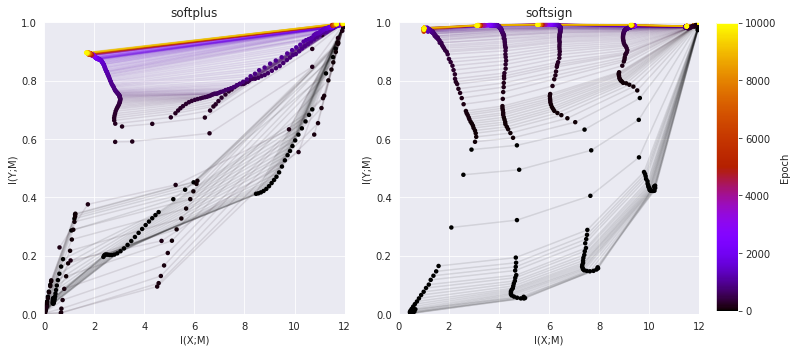

In [51]:
max_epoch = max( (max(vals.keys()) if len(vals) else 0) for vals in measures.values())
sm = plt.cm.ScalarMappable(cmap='gnuplot', norm=plt.Normalize(vmin=0, vmax=COLORBAR_MAX_EPOCHS))
sm._A = []

fig=plt.figure(figsize=(10,5))
for actndx, (activation, vals) in enumerate(measures.items()):
    epochs = sorted(vals.keys())
    if not len(epochs):
        continue
    plt.subplot(1,2,actndx+1)    
    for epoch in epochs:
        c = sm.to_rgba(epoch)
        xmvals = np.array(vals[epoch]['MI_XM_'+infoplane_measure])[PLOT_LAYERS]
        ymvals = np.array(vals[epoch]['MI_YM_'+infoplane_measure])[PLOT_LAYERS]

        plt.plot(xmvals, ymvals, c=c, alpha=0.1, zorder=1)
        plt.scatter(xmvals, ymvals, s=20, facecolors=[c for _ in PLOT_LAYERS], edgecolor='none', zorder=2)

    plt.ylim([0, 1])
    plt.xlim([0, 12])
#     plt.ylim([0, 3.5])
#     plt.xlim([0, 14])
    plt.xlabel('I(X;M)')
    plt.ylabel('I(Y;M)')
    plt.title(activation)
    
cbaxes = fig.add_axes([1.0, 0.125, 0.03, 0.8]) 
plt.colorbar(sm, label='Epoch', cax=cbaxes)
plt.tight_layout()

if DO_SAVE:
    !mkdir /content/plots
    plt.savefig('plots/' + DIR_TEMPLATE % ('infoplane_'+ARCH),bbox_inches='tight')
!cp /content/plots -r drive/MyDrive/